In [1]:
import json
import sys
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import scipy.stats as stats
import random
from scipy.stats import gaussian_kde, loguniform
from math import lgamma
from glob import glob
import os
#import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

path = '/Users/chris/Desktop/sculpting/'

In [2]:
berger_kepler = pd.read_csv(path+'berger_kepler_stellar17.csv') # crossmatched with Gaia via Bedell
print(len(berger_kepler))
print(berger_kepler.head())

19969
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
1  892667  2MASS J19243045+3637186  6609      159.0     -227.0  4.105   
2  892678  2MASS J19243108+3638316  6137      167.0     -186.0  3.936   
3  892713  2MASS J19243353+3637220  6106      186.0     -186.0  3.854   
4  892828  2MASS J19243904+3637166  6691      188.0     -235.0  4.134   

   logg_err1  logg_err2  feh_x  feh_err1  ...  parallax  parallax_err  feh_y  \
0      0.258     -0.172  -0.24      0.25  ...    1.2137        0.0220    NaN   
1      0.246     -0.164  -0.26      0.25  ...    0.8512        0.0154    NaN   
2      0.428     -0.143  -0.26      0.30  ...    1.0236        0.0259    NaN   
3      0.496     -0.124  -0.24      0.30  ...    0.9602        0.0231    NaN   
4      0.209     -0.171  -0.26      0.25  ...    0.9660        0.0143    NaN   

   feh_err    RUWE  num_gaia_companions  Kmag_final_prov  evstate      log

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# transit multiplicity from Kepler/Gaia Berger et al 2020, plus Bedell, plus Exoplanet Archive
# see isolate_with_bedell.ipynb
pnum = pd.read_csv(path+'pnum_plus_cands.csv')
print(len(pnum))
pnum = pnum.drop_duplicates(['kepid'])
print(len(pnum))
k = pnum.koi_count.value_counts() 
k = pd.Series([len(berger_kepler)-np.sum(k), 244, 51, 12, 8, 1]) 
print(k)

408
316
0    19653
1      244
2       51
3       12
4        8
5        1
dtype: int64


In [5]:
import csv
from ast import literal_eval

with open('simulations_w_geometric_transits.csv','r') as csvfile:
    read_csv = csv.reader(csvfile, delimiter='\t')
    read_csv=list(read_csv)

df = pd.DataFrame(read_csv[1:], columns=read_csv[0])
df.lams = df.lams.apply(literal_eval) # convert back from string to list of floats
df.geometric_lams = df.geometric_lams.apply(literal_eval)
df.logLs = df.logLs.apply(literal_eval)
df.geometric_logLs = df.geometric_logLs.apply(literal_eval)
df.bs = df.bs.apply(literal_eval)
df.ms = df.ms.apply(literal_eval)

df.intact_fracs = df.intact_fracs.apply(literal_eval)
geom_logLs = df.geometric_logLs
geom_lams = df.geometric_lams
logLs = df.logLs
lams = df.lams
print(df)

      ms   bs                                       intact_fracs  \
0   -1.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   -1.0  0.1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   -1.0  0.2  [0.0, 0.0, 5.00776203114828e-05, 0.0, 5.007762...   
3   -1.0  0.3  [0.0001001552406229656, 0.0001502328609344484,...   
4   -1.0  0.4  [0.0006510090640492763, 0.0004006209624918624,...   
..   ...  ...                                                ...   
116  0.0  0.6  [0.5964244579097602, 0.6007812108768591, 0.596...   
117  0.0  0.7  [0.6946266713405779, 0.7012369172216937, 0.696...   
118  0.0  0.8  [0.8031448745555612, 0.8018428564274626, 0.799...   
119  0.0  0.9  [0.9013971656066904, 0.8966397916770995, 0.902...   
120  0.0  1.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                                 logLs  \
0    [-861.3326564321698, -825.8876440117946, -825....   
1    [-799.328925833771, -777.0103471419387, -803.7...   
2    [-80

In [39]:
# if lams==1e-12, set logL to 0
def better_loglike(lam, k, flag):
    """
    Calculate Poisson log likelihood
    """
    
    logL = []
    #lam = lam.to_list() # to bypass indexing for testing
    for i in range(len(lam)):
        if flag=='a': # control
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = k[i]*np.log(lam[i])
            logL.append(term1+term2+term3)
            
        elif flag=='b': # append zero to logL
            if lam[i]==1e-12:
                logL.append(0)
            else:
                term3 = -lgamma(k[i]+1)
                term2 = -lam[i]
                term1 = k[i]*np.log(lam[i])
                logL.append(term1+term2+term3)
        
        elif flag=='c': # replace zero lam with another value approximating zero
            if lam[i]==1e-12:
                lam[i] = 1
                
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = k[i]*np.log(lam[i])
            logL.append(term1+term2+term3)
        #print(lam[i])
        #print(logL)
    return np.sum(logL)

In [40]:
# high initial; low decline
print(df.loc[(df.ms == 0) & (df.bs == 1)].lams.to_list()[0][0])
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 1)].lams.to_list()[0][0], k, 'a'))
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 1)].lams.to_list()[0][0], k, 'b'))
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 1)].lams.to_list()[0][0], k, 'c'))


[18311.0, 844.0, 442.0, 232.0, 106.0, 28.0]
-929.0915782056396
-929.0915782056396
-929.0915782056396


In [41]:
# low initial; no decline
print(df.loc[(df.ms == 0) & (df.bs == 0)].lams.to_list()[0][0])
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 0)].lams.to_list()[0][0], k, 'a'))
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 0)].lams.to_list()[0][0], k, 'b'))
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 0)].lams.to_list()[0][0], k, 'c'))

[19215.0, 712.0, 42.0, 1e-12, 1e-12, 1e-12]
-835.8140723635021
-224.9708115305924
-258.5626289289995


In [42]:
# low initial; fast decline
print(df.loc[(df.ms == -1) & (df.bs == 0)].lams.to_list()[0][0])
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0)].lams.to_list()[0][0], k, 'a'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0)].lams.to_list()[0][0], k, 'b'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0)].lams.to_list()[0][0], k, 'c'))


[19178.0, 749.0, 42.0, 1, 1, 1]
-284.0812129976672
-284.0812129976672
-284.0812129976672


In [43]:
# high initial; fast decline
print(df.loc[(df.ms == -1) & (df.bs == 1)].lams.to_list()[0][0])
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 1)].lams.to_list()[0][0], k, 'a'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 1)].lams.to_list()[0][0], k, 'b'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 1)].lams.to_list()[0][0], k, 'c'))

[19211.0, 688.0, 56.0, 8.0, 5.0, 1.0]
-215.5201800205563
-215.5201800205563
-215.5201800205563


In [44]:
# multimodal population
print(df.loc[(df.ms == -1) & (df.bs == 0.6)].lams.to_list()[0][0])
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0.6)].lams.to_list()[0][0], k, 'a'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0.6)].lams.to_list()[0][0], k, 'b'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0.6)].lams.to_list()[0][0], k, 'c'))

[19232.0, 695.0, 42.0, 1, 1, 1]
-247.07932629048028
-247.07932629048028
-247.07932629048028


### Young vs old systems

Do I get more multis in young systems versus old ones? It should be no difference for b=0 case, but more multis in young for cases that don't decay to P(intact)=0 so quickly from a high enough b. 

In [ ]:
# pick two CSVs from five different cases: 
# b = 0; m = 0 
# b = 0; m = -0.5; distribution of planets and transits should be same as above
# m = -1; b = 0
# m = -1; b = 0.5; should be slightly shallower than above
# m = -0.5; b = 1; should be shallower than above

# split each datafrmae into young and old

# for each, plot transit multiplicity and num_planets plots

In [48]:
a = pd.read_csv('young_old_test_data/transits0_0_1.csv')
b = pd.read_csv('young_old_test_data/transits5_0_1.csv')
a.planet_inclinations = a.planet_inclinations.apply(literal_eval)
a['num_planets'] = a.planet_inclinations.str.len()
b['num_planets'] = b.planet_inclinations.str.len()
a_young = a.loc[a.star_ages <= 1.]
a_old = a.loc[a.star_ages > 1.]
b_young = b.loc[b.star_ages <= 1.]
b_old = b.loc[b.star_ages > 1.]

0    2430
1      79
2       5
Name: transit_multiplicity, dtype: int64
0    16782
1      618
2       55
Name: transit_multiplicity, dtype: int64


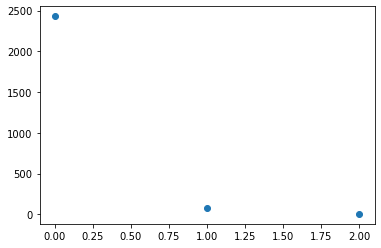

In [55]:
print(a_young.transit_multiplicity.value_counts())
print(a_old.transit_multiplicity.value_counts())
plt.scatter(np.arange(3), a_young.transit_multiplicity.value_counts())

In [ ]:
plt.scatter(pd.Series())

In [ ]:
from itertools import zip_longest
import numpy.ma as ma # for masked arrays
plt.figure(figsize=(16,16))
index = 0

short_k = k*1000/np.sum(k)
lam_upper = []
lam_lower = []
lam_avgs = []
for gi_m in range(11):
    for gi_b in range(11):
        # avg, max, and min transit multiplicities to compare against data
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        lam_elt = lams[index]
        lam_elt_max = []
        lam_elt_min = []
        lam_elt_avg = []
        for temp_list in zip_longest(*lam_elt):
            elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
            lam_elt_max.append(max(elt))
            lam_elt_min.append(min(elt))
            lam_elt_avg.append(np.mean(elt))
        
        lam_upper.append(lam_elt_max)
        lam_lower.append(lam_elt_min)
        lam_avgs.append(lam_elt_avg)

        # plotting
        ax.scatter(pd.Series(lam_elt_avg).index, lam_elt_avg, s=10)
        ax.scatter(pd.Series(lam_elt_max).index, lam_elt_max, s=10)
        ax.scatter(pd.Series(lam_elt_min).index, lam_elt_min, s=10)
        ax.scatter(np.arange(5), nonzero_k, marker=(5, 1), color='r', s=10)
        ax.scatter(np.arange(5), nonzero_k+np.sqrt(nonzero_k), marker='+', s=10)
        ax.scatter(np.arange(5), nonzero_k-np.sqrt(nonzero_k), marker='+', s=10)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        #ax.set_ylim([0, 30])
        
        # draw envelope
        ax.fill_between(np.arange(len(lam_elt_min)), lam_elt_min, lam_elt_max, alpha=0.6)

        index += 1
plt.show()